<a href="https://colab.research.google.com/github/PascalLiPooKim/Football-prediction-model-project/blob/build-models/footballPredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports

In [2]:
import pandas as pd
import missingno as msn
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from joblib import dump, load
from google.colab import files


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import RocCurveDisplay, classification_report
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score

# Exploratory Data Analysis (EDA)

## Team Info

In [18]:
team_info_df = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Team_Info.csv')
team_info_df.head()

,Team,City,Country,Stadium,Capacity,Pitch
0,Wattenscheid 09,Bochum-Wattenscheid,Germany,Lohrheidestadion,16233,Natural
1,Hertha BSC,Berlín,Germany,Olympiastadion Berlin,76065,Natural
2,Unterhaching,Unterhaching,Germany,Sportpark Unterhaching,15053,Natural
3,Fortuna Köln,Cologne,Germany,Südstadion,14944,Natural
4,MSV Duisburg,Duisburgo,Germany,Schauinsland-Reisen-Arena,31514,Natural


In [19]:
team_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Team      544 non-null    object
 1   City      544 non-null    object
 2   Country   544 non-null    object
 3   Stadium   447 non-null    object
 4   Capacity  544 non-null    object
 5   Pitch     447 non-null    object
dtypes: object(6)
memory usage: 25.6+ KB


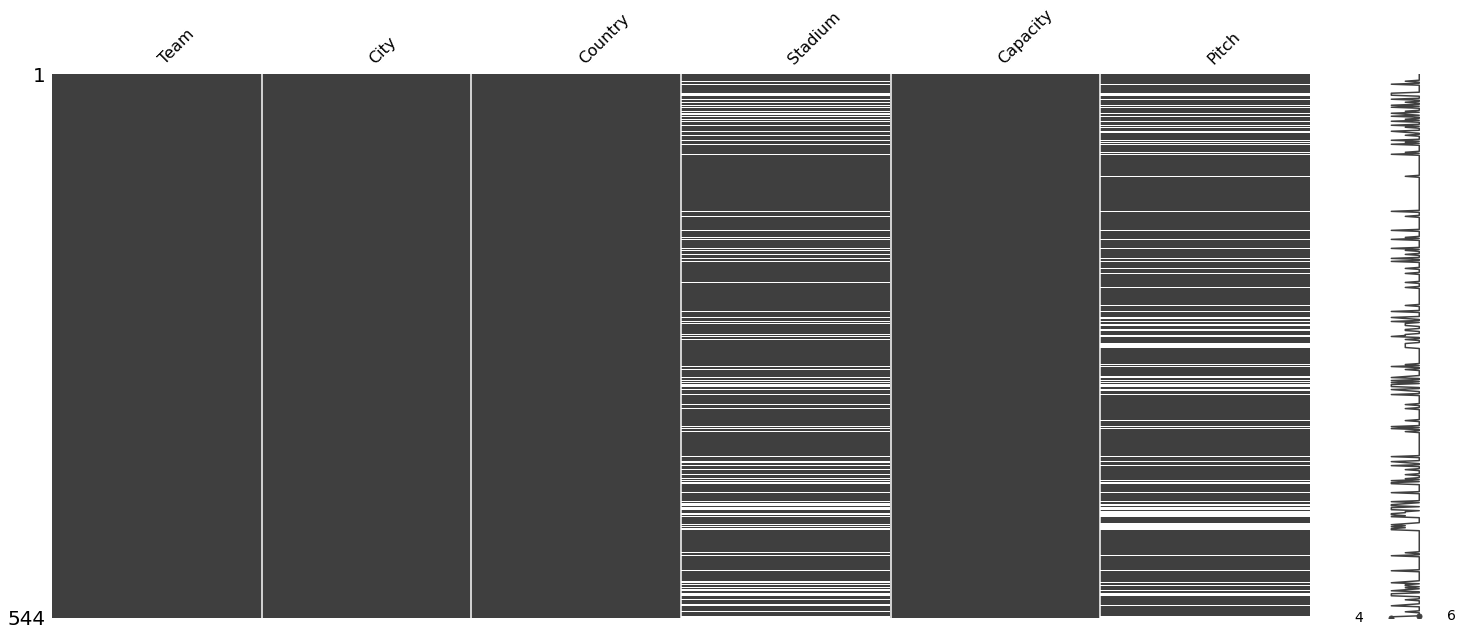

In [20]:
msn.matrix(team_info_df)

In [21]:
team_info_df.isnull().sum()/len(team_info_df)

Team        0.000000
City        0.000000
Country     0.000000
Stadium     0.178309
Capacity    0.000000
Pitch       0.178309
dtype: float64

In [22]:
team_info_cols_with_null = ['Stadium', 'Pitch']
for col in team_info_cols_with_null:
  print(team_info_df[col].value_counts()/len(team_info_df))
  # print(team_info_df[col].unique())
  # print(team_info_df[team_info_df[col].isnull()])

Stadio Marc'Antonio Bentegodi           0.003676
Cerro del Espino                        0.003676
Cartagonova                             0.003676
Stadio Atleti Azzurri d'Italia          0.003676
Stadio Città del Tricolore              0.003676
                                          ...   
Ennio Tardini                           0.001838
Eintracht-Stadion                       0.001838
Stadio Adriatico-Giovanni Cornacchia    0.001838
Kingston Communications Stadium         0.001838
Volksparkstadion                        0.001838
Name: Stadium, Length: 442, dtype: float64
Natural              0.648897
Grass                0.055147
Césped natural       0.038603
Césped Artificial    0.029412
grass                0.014706
Césped Natural       0.011029
Artificial           0.003676
natural              0.003676
Césped               0.003676
Natural grass        0.001838
Cesped natural       0.001838
natural grass        0.001838
AirFibr              0.001838
cesped natural       0.00183

In [23]:
team_info_df['Stadium'].unique()

array(['Lohrheidestadion', 'Olympiastadion Berlin',
       'Sportpark Unterhaching', 'Südstadion',
       'Schauinsland-Reisen-Arena', 'Stadion Ludwigspark',
       'Eintracht-Stadion', nan, 'osnatel-ARENA', 'MEP-Arena',
       'VELTINS-Arena', 'Stadion Essen', 'Schwarzwald-Stadion',
       'Neuer Tivoli', 'Merck-Stadion am Böllenfalltor', 'HDI-Arena',
       'GAZİ-Stadion auf der Waldau', 'Preußen-Stadion', 'Opel Arena',
       'Marschwegstadion', 'Wilhelm-Langrehr-Stadion', 'ERDGAS Sportpark',
       'Ernst-Abbe-Sportfeld', 'Steigerwaldstadion', 'Grünwalder Stadion',
       'Volkswagen-Arena', 'DKB Arena', 'Millerntor-Stadion',
       'ESPRIT arena', 'rewirpowerSTADION',
       'Frankfurter Volksbank Stadion', 'Grundig-Stadion', 'SchücoArena',
       'Commerzbank-Arena', 'Fritz-Walter-Stadion',
       'Sportpark Ronhof Thomas Sommer',
       'Stadion der Freundschaft, Cottbus', 'RheinEnergieStadion',
       'Stadion Niederrhein', 'Wildparkstadion', 'Bieberer Berg Stadion',
       'Bo

In [24]:
team_info_df['Stadium'].replace(to_replace={np.nan: 'Other'}, inplace=True)

In [25]:
team_info_df['Country'].unique()

array(['Germany', 'England', 'Netherlands', 'France', 'Portugal', 'Spain',
       'Italy'], dtype=object)

In [26]:
england_teams = team_info_df[team_info_df['Country'] == 'England']
# 'Charlton Athletic' in england_teams
england_teams

,Team,City,Country,Stadium,Capacity,Pitch
87,West Ham,Londres,England,London Stadium,80000,Natural
88,Blackburn Rovers,Blackburn,England,Ewood Park,31367,Natural
89,Sheffield United,Sheffield,England,Bramall Lane,32702,Natural
90,Ipswich Town,Ipswich,England,Portman Road Stadium,30311,Natural
91,Sunderland,Sunderland,England,Stadium of Light,49000,Natural
...,...,...,...,...,...,...
278,Aston Villa,Birmingham,England,Villa Park,42788,Natural
279,Southampton,Southampton,England,St. Mary's Stadium,32689,Natural
280,Everton,Liverpool,England,Goodison Park,40569,Natural
281,Arsenal,Londres,England,Emirates Stadium,60355,Natural


In [27]:
team_info_df['Pitch'].unique()

array(['Natural', 'grass', 'Césped', nan, 'cesped natural', 'Grass',
       'cesped real', 'NATURAL', 'Césped Artificial', 'AirFibr ',
       'Natural grass', 'Césped Natural', 'Cesped natural',
       'Césped natural', 'natural grass', 'Artificial', 'natural'],
      dtype=object)

In [28]:
fig = px.histogram(team_info_df, x="Pitch")
fig.show()

In [29]:
team_info_df[team_info_df['Pitch'] == 'Grass']

,Team,City,Country,Stadium,Capacity,Pitch
27,Carl Zeiss Jena,Jena,Germany,Ernst-Abbe-Sportfeld,16000,Grass
28,Chemnitzer,Chemnitz,Germany,Other,16061,Grass
37,FC Remscheid,Remscheid,Germany,Other,"12,463",Grass
59,SV Babelsberg 03,Potsdam,Germany,Karl-Liebknecht-Stadion,"10,787",Grass
61,Eintracht Trier,Tréveris,Germany,Other,"10,256",Grass
120,Grimsby Town,Grimsby,England,Blundell Park,9546,Grass
125,Luton Town,Luton,England,Kenilworth Road Stadium,"10,356",Grass
142,Wimbledon FC,London,England,Other,"15,876",Grass
176,FC Omniworld,Almere,Netherlands,Other,"4,501",Grass
180,Jong Twente,Enschede,Netherlands,Other,"30,205",Grass


In [30]:
team_info_df[team_info_df['Pitch'] == 'Césped']

,Team,City,Country,Stadium,Capacity,Pitch
8,VfL Osnabrück,Osnabrück,Germany,osnatel-ARENA,16130,Césped
55,Kickers Offenbach,Offenbach,Germany,Bieberer Berg Stadion,25200,Césped


In [31]:
team_info_df[team_info_df['Pitch'].isna()]

,Team,City,Country,Stadium,Capacity,Pitch
10,Blau-Weiß 1890 B.,Berlin,Germany,Other,3000,NaN
19,Bayreuth SpVgg,Bayreuth,Germany,Other,21500,NaN
20,Waldhof Mannheim,Mannheim,Germany,Other,"25,667",NaN
21,FC 08 Homburg,Homburg,Germany,Other,"16,488",NaN
25,Schweinfurt,Schweinfurt,Germany,Other,15060,NaN
...,...,...,...,...,...,...
520,FC Savoia 1908,Savoia,Italy,Other,12750,NaN
521,Fermana,Fermana,Italy,Other,8850,NaN
531,Calcio,Foggia,Italy,Other,16000,NaN
542,Pordenone,Pordenone,Italy,Other,3089,NaN


In [32]:
import itertools
replace_from = ['Natural', 'grass', 'natural', 'natural grass', 'NATURAL', 
                'Natural grass', 'Grass', np.nan]
replace_to = ['Natural Grass']
to_replace = dict(itertools.product(replace_from, replace_to))

replace_from = ['Cesped natural', 'cesped natural', 'Césped natural', 
                'cesped real', 'Césped']
replace_to = ['Césped Natural']
to_replace.update(dict(itertools.product(replace_from, replace_to)))

replace_from = ['AirFibr ', 'Artificial']
replace_to = ['Césped Artificial']
to_replace.update(dict(itertools.product(replace_from, replace_to)))

team_info_df['Pitch'].replace(to_replace=to_replace, inplace=True)
team_info_df['Pitch'].unique()

# team_info_df['Pitch'].replace(to_replace={np.nan: 'Other'}, inplace=True)

# team_info_df['Pitch'].unique()

array(['Natural Grass', 'Césped Natural', 'Césped Artificial'],
      dtype=object)

In [33]:
fig = px.histogram(team_info_df, x="Pitch")
fig.show()

In [34]:
def categories_encoder_decoder(df, cols_with_null):
  category_dict_encode = {}
  category_dict_decode = {}
  for col in cols_with_null:
      # le = LabelEncoder()
      df[col] = df[col].astype('category')
      # le.fit(team_info_df[col])
      # team_info_df[col] = le.transform(team_info_df[col])
      # print(le.classes_)
      categories = df[col].cat.categories
      
      col_cat_dict = dict(enumerate(categories))
      # print("Column, Category dict:", col_cat_dict)
      category_dict_decode[col] = col_cat_dict
      
      col_cat_dict = {v:k for k,v in col_cat_dict.items()}
      # print("Inverted Column, Category dict:", col_cat_dict)
      category_dict_encode[col] = col_cat_dict

  return category_dict_encode, category_dict_decode

In [35]:
# from sklearn.impute import KNNImputer
# from sklearn.preprocessing import LabelEncoder

# category_dict_encode, category_dict_decode = categories_encoder_decoder(team_info_df, ['Pitch'])

# print("Category dict ENCODE:", category_dict_encode)
# print("Category dict DECODE:", category_dict_decode)
# team_info_df.replace(category_dict_encode, inplace=True)
# team_info_df

In [36]:
# knn_impute = KNNImputer(n_neighbors=3, weights="distance")
# knn_team_info_arr = knn_impute.fit_transform(team_info_df[team_info_cols_with_null])
# knn_team_info_df = pd.DataFrame(knn_team_info_arr.astype('int64'), columns = team_info_df[team_info_cols_with_null].columns)
# knn_team_info_df

In [37]:
# knn_team_info_df.replace(category_dict_decode, inplace=True)
# knn_team_info_df

## Match Info

In [38]:
match_info_df = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Match_Info.csv')
match_info_df.head()

,Link,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red
0,/match/saarbrucken/stuttgarter-kickers/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Hans-Jürgen Weber\n,0.0,0.0,3.0,0.0
1,/match/sc-freiburg/unterhaching/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Kurt Wittke\n,1.0,0.0,0.0,0.0
2,/match/vfl-osnabruck/meppen/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Werner Föckler\n,3.0,0.0,2.0,0.0
3,/match/rot-weiss-essen/schalke-04/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Heinz Werner\n,2.0,0.0,2.0,0.0
4,/match/alemannia-aachen/msv-duisburg/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Hans-Peter Dellwing\n,1.0,0.0,1.0,0.0


In [39]:
match_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143348 entries, 0 to 143347
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Link         143348 non-null  object 
 1   Date_New     143348 non-null  object 
 2   Referee      143348 non-null  object 
 3   Home_Yellow  122798 non-null  float64
 4   Home_Red     122798 non-null  float64
 5   Away_Yellow  122798 non-null  float64
 6   Away_Red     122798 non-null  float64
dtypes: float64(4), object(3)
memory usage: 7.7+ MB


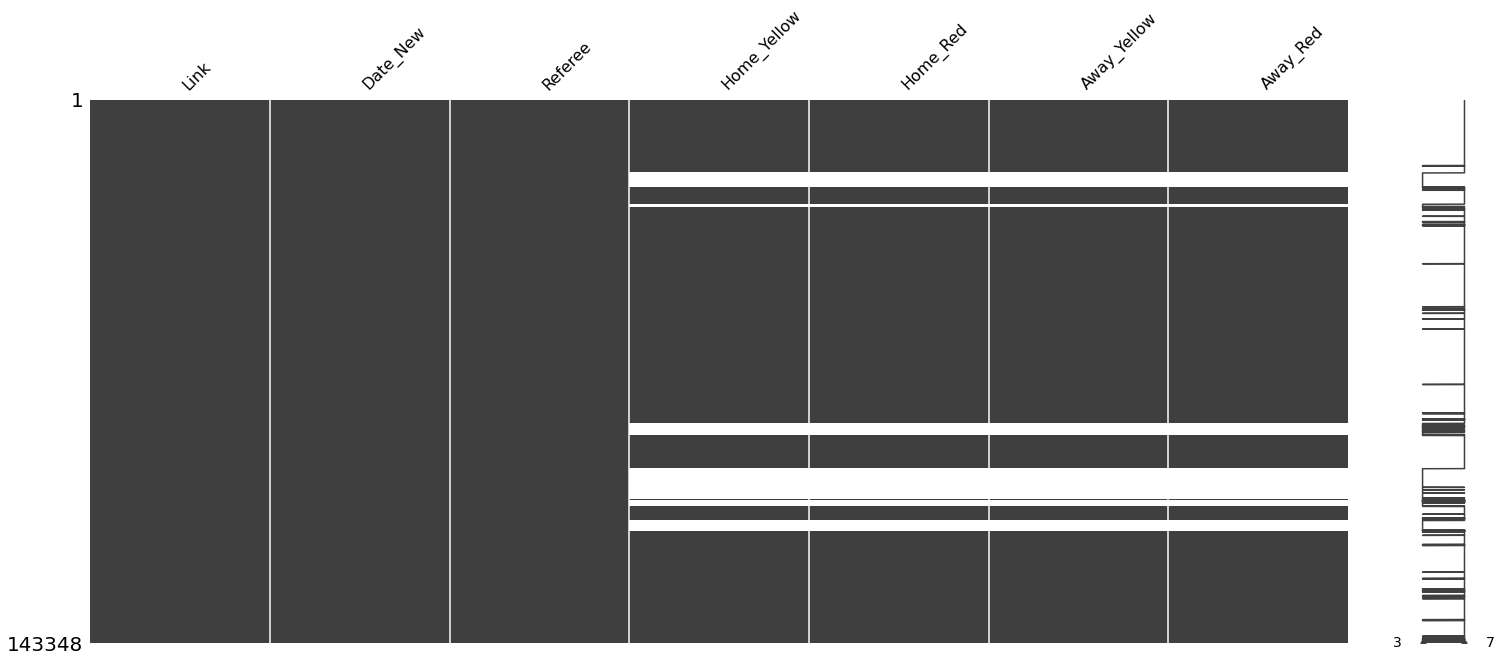

In [40]:
msn.matrix(match_info_df)

In [41]:
match_info_df.isnull().sum()/len(match_info_df)

Link           0.000000
Date_New       0.000000
Referee        0.000000
Home_Yellow    0.143357
Home_Red       0.143357
Away_Yellow    0.143357
Away_Red       0.143357
dtype: float64

In [42]:
match_info_cols_with_null = ['Home_Yellow', 'Home_Red', 'Away_Yellow', 'Away_Red']
match_info_cols_with_null

['Home_Yellow', 'Home_Red', 'Away_Yellow', 'Away_Red']

In [43]:


for col in match_info_cols_with_null:
  print(match_info_df[col].unique())
  match_info_df[col].replace(to_replace={np.nan: 0}, inplace=True)
  print(match_info_df[col].unique())

[ 0.  1.  3.  2.  4.  5.  6.  7.  8. nan  9. 10.]
[ 0.  1.  3.  2.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  3.  2. nan]
[0. 1. 3. 2.]
[ 3.  0.  2.  1.  4.  6.  5.  8.  7.  9. nan 10.]
[ 3.  0.  2.  1.  4.  6.  5.  8.  7.  9. 10.]
[ 0.  1.  2.  3. nan  4.]
[0. 1. 2. 3. 4.]


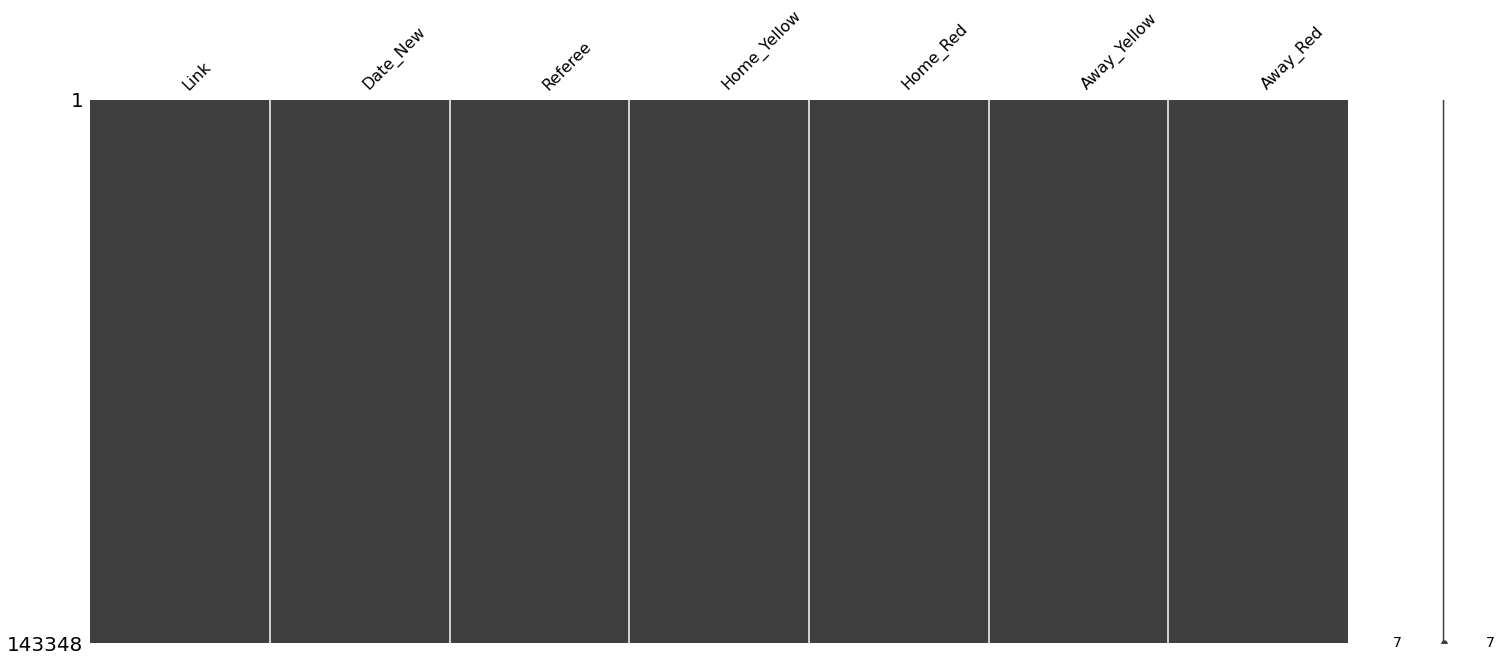

In [44]:
msn.matrix(match_info_df)

In [45]:
match_info_df['Date_New'] = pd.to_datetime(match_info_df['Date_New'])
match_info_df['Referee'] = match_info_df['Referee'].str.strip().str.split(':').str[-1].str.strip()
match_info_df['Referee'].replace(to_replace={'':'Other'}, inplace=True)
match_info_df
# type(match_info_df['Referee'].str.strip().str.split(':'))

,Link,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red
0,/match/saarbrucken/stuttgarter-kickers/1990,1989-07-29 15:00:00,Hans-Jürgen Weber,0.0,0.0,3.0,0.0
1,/match/sc-freiburg/unterhaching/1990,1989-07-29 15:00:00,Kurt Wittke,1.0,0.0,0.0,0.0
2,/match/vfl-osnabruck/meppen/1990,1989-07-29 15:00:00,Werner Föckler,3.0,0.0,2.0,0.0
3,/match/rot-weiss-essen/schalke-04/1990,1989-07-29 15:00:00,Heinz Werner,2.0,0.0,2.0,0.0
4,/match/alemannia-aachen/msv-duisburg/1990,1989-07-29 15:00:00,Hans-Peter Dellwing,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
143343,/match/sunderland-afc/oxford-city/1999,1998-09-19 00:00:00,Anthony Leake,1.0,0.0,0.0,0.0
143344,/match/fc-gueugnon/bastia/1994,1994-05-17 00:00:00,Jacques Poulain,0.0,0.0,0.0,0.0
143345,/match/tranmere-rovers/wolverhampton/1999,1999-01-08 00:00:00,Kevin Lynch,2.0,0.0,1.0,0.0
143346,/match/sochaux/guingamp/2021,2021-02-27 19:00:00,Baert A.,0.0,0.0,2.0,0.0


In [46]:
# teams_played_ls = []
home_teams = []
away_teams = []
seasons = []
for i, row in match_info_df.iterrows():
  # teams_played_ls.append(row['Link'].split('/')[2:])
  e = row['Link'].split('/')
  home_teams.append(e[2].replace('-', ' ').replace('afc', '').replace('fc', ''))
  away_teams.append(e[3].replace('-', ' ').replace('afc', '').replace('fc', ''))
  seasons.append(e[4])

# match_info_df['Teams_Played_Year'] = teams_played_ls
match_info_df['Home_Team'] = home_teams
match_info_df['Away_Team'] = away_teams
match_info_df['Season'] = seasons
match_info_df

,Link,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Home_Team,Away_Team,Season
0,/match/saarbrucken/stuttgarter-kickers/1990,1989-07-29 15:00:00,Hans-Jürgen Weber,0.0,0.0,3.0,0.0,saarbrucken,stuttgarter kickers,1990
1,/match/sc-freiburg/unterhaching/1990,1989-07-29 15:00:00,Kurt Wittke,1.0,0.0,0.0,0.0,sc freiburg,unterhaching,1990
2,/match/vfl-osnabruck/meppen/1990,1989-07-29 15:00:00,Werner Föckler,3.0,0.0,2.0,0.0,vfl osnabruck,meppen,1990
3,/match/rot-weiss-essen/schalke-04/1990,1989-07-29 15:00:00,Heinz Werner,2.0,0.0,2.0,0.0,rot weiss essen,schalke 04,1990
4,/match/alemannia-aachen/msv-duisburg/1990,1989-07-29 15:00:00,Hans-Peter Dellwing,1.0,0.0,1.0,0.0,alemannia aachen,msv duisburg,1990
...,...,...,...,...,...,...,...,...,...,...
143343,/match/sunderland-afc/oxford-city/1999,1998-09-19 00:00:00,Anthony Leake,1.0,0.0,0.0,0.0,sunderland,oxford city,1999
143344,/match/fc-gueugnon/bastia/1994,1994-05-17 00:00:00,Jacques Poulain,0.0,0.0,0.0,0.0,gueugnon,bastia,1994
143345,/match/tranmere-rovers/wolverhampton/1999,1999-01-08 00:00:00,Kevin Lynch,2.0,0.0,1.0,0.0,tranmere rovers,wolverhampton,1999
143346,/match/sochaux/guingamp/2021,2021-02-27 19:00:00,Baert A.,0.0,0.0,2.0,0.0,sochaux,guingamp,2021


In [47]:
ls = match_info_df['Referee'].unique()
ls.sort()
print(ls)

['A. Castro' 'A. Delerue' 'A. Gautier' ... 'Ángel Calvo Córdova'
 'Ã‰ric Poulat' 'Éric Poulat']


In [48]:
val = {'manchester city': 'man. city', 
       'manchester utd': 'man. utd',
       'borussia dortmund': 'b. dortmund',
       'borussia leverkusen':'b. leverkusen',
       'borussia monchengla': 'b. mönchengladbach',
       'athletic bilbao': 'atlético b'}


to_replace= {'Home_Team': val, 'Away_Team': val,}
match_info_df.replace(to_replace=to_replace, inplace=True)

## Results

### Premier League

#### 1990 Season

In [49]:
pl_1990 = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Results/premier_league/Results_1990_premier_league.csv')
pl_1990.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league


In [50]:
pl_1990.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  380 non-null    object
 1   Away_Team  380 non-null    object
 2   Result     380 non-null    object
 3   Link       380 non-null    object
 4   Season     380 non-null    int64 
 5   Round      380 non-null    int64 
 6   League     380 non-null    object
dtypes: int64(2), object(5)
memory usage: 20.9+ KB


In [51]:
pl_1990['Home_Team'].unique()

array(['Charlton Athletic', 'Tottenham Hotspur', 'Southampton',
       'Sheffield Wednesday', 'Queens Park Rangers', 'Nottingham Forest',
       'Man. Utd', 'Liverpool', 'Coventry City', 'Wimbledon FC',
       'Arsenal', 'Millwall', 'Luton Town', 'Everton', 'Crystal Palace',
       'Chelsea', 'Aston Villa', 'Derby County', 'Man. City',
       'Norwich City'], dtype=object)

In [52]:
# pl_1990['Home_Team'].replace(to_replace={'Man. City':'Manchester City', 'Man. Utd': 'Manchester Utd'}, inplace=True)


In [53]:
def add_referee_cards_cols(df, ref_default ='Other'):
  df['Referee'] = ref_default
  df['Home_Yellow'] = 0
  df['Home_Red'] = 0
  df['Away_Yellow'] = 0
  df['Away_Red'] = 0
  for i, row in df.iterrows():
      first_cond = match_info_df['Home_Team'] == row['Home_Team'].lower()
      if first_cond.any():
        second_cond = row['Away_Team'].lower() == match_info_df[first_cond]['Away_Team']
        if second_cond.any():
          third_cond = match_info_df[first_cond][second_cond]['Season'].astype('int64') == int(row['Season'])
          if third_cond.any():
            # print(i, match_info_df[first_cond][second_cond][third_cond]['Referee'].to_numpy())
            df.loc[i, 'Referee'] = match_info_df[first_cond][second_cond][third_cond]['Referee'].to_numpy()[0]
            df.loc[i, 'Home_Yellow'] = match_info_df[first_cond][second_cond][third_cond]['Home_Yellow'].to_numpy()[0]
            df.loc[i, 'Home_Red'] = match_info_df[first_cond][second_cond][third_cond]['Home_Red'].to_numpy()[0]
            df.loc[i, 'Away_Yellow'] = match_info_df[first_cond][second_cond][third_cond]['Away_Yellow'].to_numpy()[0]
            df.loc[i, 'Away_Red'] = match_info_df[first_cond][second_cond][third_cond]['Away_Red'].to_numpy()[0]
  return df

pl_1990 = add_referee_cards_cols(pl_1990)
pl_1990['Referee'].unique()

# for i in match_info_df['Home_Team'].to_numpy():
#   print(i)

array(['Other', 'Frangcon Roberts'], dtype=object)

In [54]:
def add_pitch_col(df, init_default='Césped Artificial'):
  df['Pitch'] = init_default
  team_checked = []
  for i, row in df.iterrows():
    # print(team_info_df['Team'][team_info_df['Team'].str.lower()=='liverpool'])
    # break
    # print(row['Home_Team'])
    cond = row['Home_Team'].lower() == team_info_df['Team'].str.lower()
    if cond.any() and row['Home_Team'].lower() not in team_checked:
      # print(i, team_info_df[cond]['Team'].to_numpy()[0])
      # team = team_info_df[cond]['Team'].to_numpy()[0]
      team_checked.append(row['Home_Team'].lower())
      # cond = team_info_df['Team'].str.lower() == row['Home_Team'].lower()
      df.loc[i, 'Pitch'] = team_info_df[cond]['Pitch'].to_numpy()[0]

  return df

pl_1990 = add_pitch_col(pl_1990)
pl_1990.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Pitch
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league,Other,0.0,0.0,0.0,0.0,Natural Grass
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league,Other,0.0,0.0,0.0,0.0,Natural Grass
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league,Other,0.0,0.0,0.0,0.0,Natural Grass
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league,Other,0.0,0.0,0.0,0.0,Césped Artificial
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league,Other,0.0,0.0,0.0,0.0,Césped Artificial


#### 1990 - 2021 Seasons

In [55]:
results_pl = []
for season in range(1990, 2022):
  df = pd.read_csv(f'https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Results/premier_league/Results_{season}_premier_league.csv')
  df.info()
  results_pl.append(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  380 non-null    object
 1   Away_Team  380 non-null    object
 2   Result     380 non-null    object
 3   Link       380 non-null    object
 4   Season     380 non-null    int64 
 5   Round      380 non-null    int64 
 6   League     380 non-null    object
dtypes: int64(2), object(5)
memory usage: 20.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  380 non-null    object
 1   Away_Team  380 non-null    object
 2   Result     380 non-null    object
 3   Link       380 non-null    object
 4   Season     380 non-null    int64 
 5   Round      380 non-null    int64 
 6   League     380 non-null    object
dtypes: int64(2), object(5)
memory usag

In [56]:
pl_df = pd.concat(results_pl).reset_index().drop(labels=['index'], axis = 1)
pl_df.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league


In [57]:
pl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12417 entries, 0 to 12416
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  12417 non-null  object
 1   Away_Team  12417 non-null  object
 2   Result     12417 non-null  object
 3   Link       12417 non-null  object
 4   Season     12417 non-null  int64 
 5   Round      12417 non-null  int64 
 6   League     12417 non-null  object
dtypes: int64(2), object(5)
memory usage: 679.2+ KB


In [58]:
pl_df.isnull().sum()/len(pl_df)

Home_Team    0.0
Away_Team    0.0
Result       0.0
Link         0.0
Season       0.0
Round        0.0
League       0.0
dtype: float64

In [59]:
pl_df.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league


In [60]:
pl_df['Result'].unique()

array(['0-0', '2-1', '1-2', '0-2', '2-0', '1-1', '4-1', '3-1', '0-1',
       '2-2', '1-0', '3-0', '4-0', '9-0', '0-3', '5-0', '4-4', '3-2',
       '1-4', '5-1', '1-3', '4-3', '6-2', '6-0', '2-3', '6-3', '2-5',
       '4-2', '2-4', '3-3', '0-4', '1-6', '6-1', '1-5', '4-6', '2-6',
       '3-4', '1-7', '4-5', '7-0', '5-2', '3-5', '3-6', '7-1', '5-3',
       '0-5', '0-6', '7-2', '1-8', '8-0', '5-4', '7-4', '6-4', '8-1',
       '9-1', '8-2', '7-3', '5-5', '0-9', '0-7', '17 JAN'], dtype=object)

In [61]:
print(pl_df[pl_df['Result'] == '17 JAN'])
pl_df = pl_df[pl_df['Result'] != '17 JAN']
pl_df

         Home_Team Away_Team  Result  ... Season  Round          League
12293  Aston Villa   Everton  17 JAN  ...   2021     19  premier_league

[1 rows x 7 columns]


,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league
...,...,...,...,...,...,...,...
12412,West Ham,Leicester,3-2,https://www.besoccer.com/match/west-ham-united...,2021,31,premier_league
12413,Tottenham Hotspur,Man. Utd,1-3,https://www.besoccer.com/match/tottenham-hotsp...,2021,31,premier_league
12414,Sheffield United,Arsenal,0-3,https://www.besoccer.com/match/sheffield-unite...,2021,31,premier_league
12415,West Bromwich Albion,Southampton,3-0,https://www.besoccer.com/match/west-bromwich/s...,2021,31,premier_league


In [62]:
def score_to_result(df, col):
  home_team_results = []
  for i, row in df.iterrows():
    ls = row[col].split('-')
    # print(ls)
    if int(ls[0]) > int(ls[1]):
      # print('Draw')
      home_team_results.append('Win')
    elif int(ls[0]) < int(ls[1]):
      home_team_results.append('Loss')
    else:
      home_team_results.append('Draw')
  return home_team_results

pl_df['Home_Team_Outcome'] = score_to_result(pl_df, 'Result')
pl_df

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league,Draw
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league,Win
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league,Loss
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league,Loss
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league,Win
...,...,...,...,...,...,...,...,...
12412,West Ham,Leicester,3-2,https://www.besoccer.com/match/west-ham-united...,2021,31,premier_league,Win
12413,Tottenham Hotspur,Man. Utd,1-3,https://www.besoccer.com/match/tottenham-hotsp...,2021,31,premier_league,Loss
12414,Sheffield United,Arsenal,0-3,https://www.besoccer.com/match/sheffield-unite...,2021,31,premier_league,Loss
12415,West Bromwich Albion,Southampton,3-0,https://www.besoccer.com/match/west-bromwich/s...,2021,31,premier_league,Win


In [63]:
fig = px.histogram(pl_df, x="Home_Team_Outcome")
fig.show()
pl_df['Home_Team_Outcome'].value_counts()/len(pl_df) * 100

Win     46.085696
Loss    27.762564
Draw    26.151740
Name: Home_Team_Outcome, dtype: float64

In [64]:
unique_pl_teams = set()
unique_pl_teams.update(pl_df['Home_Team'])
unique_pl_teams.update(pl_df['Away_Team'])
unique_pl_teams

{'AFC Bournemouth',
 'Arsenal',
 'Aston Villa',
 'Barnsley',
 'Birmingham City',
 'Blackburn Rovers',
 'Blackpool',
 'Bolton Wanderers',
 'Bradford City',
 'Brighton & Hove Albion',
 'Burnley',
 'Cardiff City',
 'Charlton Athletic',
 'Chelsea',
 'Coventry City',
 'Crystal Palace',
 'Derby County',
 'Everton',
 'Fulham',
 'Huddersfield Town',
 'Hull City',
 'Ipswich Town',
 'Leeds United',
 'Leicester',
 'Liverpool',
 'Luton Town',
 'Man. City',
 'Man. Utd',
 'Middlesbrough',
 'Millwall',
 'Newcastle',
 'Norwich City',
 'Nottingham Forest',
 'Notts County',
 'Oldham Athletic AFC',
 'Portsmouth',
 'Queens Park Rangers',
 'Reading',
 'Sheffield United',
 'Sheffield Wednesday',
 'Southampton',
 'Stoke City',
 'Sunderland',
 'Swansea City',
 'Swindon Town',
 'Tottenham Hotspur',
 'Watford',
 'West Bromwich Albion',
 'West Ham',
 'Wigan Athletic',
 'Wimbledon FC',
 'Wolves'}

In [65]:
pl_df.columns

Index(['Home_Team', 'Away_Team', 'Result', 'Link', 'Season', 'Round', 'League',
       'Home_Team_Outcome'],
      dtype='object')

In [66]:
pl_df = add_referee_cards_cols(pl_df)
pl_df['Referee'].unique()

KeyboardInterrupt: ignored

In [ ]:
pl_df = add_pitch_col(pl_df)
pl_df['Pitch'].unique()

In [ ]:
category_dict_encode = {}
category_dict_decode = {}
    

# print("Column, Category dict:", col_cat_dict)
for col in ['Home_Team', 'Away_Team']:
  col_cat_dict = dict(enumerate(unique_pl_teams))
  category_dict_decode[col] = col_cat_dict

  col_cat_dict = {v:k for k,v in col_cat_dict.items()}
  # print("Inverted Column, Category dict:", col_cat_dict)
  category_dict_encode[col] = col_cat_dict

# print()
print("Category dict ENCODE:", category_dict_encode)
# print("Category dict DECODE:", category_dict_decode)
pl_teams_encoded_df = pl_df.replace(category_dict_encode)
pl_teams_encoded_df
# category_dict_encode['Away_Team']
# df = pl_df.replace(category_dict_encode)
# df

In [ ]:
category_dict_encode, category_dict_decode = categories_encoder_decoder(pl_df, ['Referee'])
pl_teams_encoded_df.replace(category_dict_encode, inplace=True)
pl_teams_encoded_df

In [ ]:
pl_teams_encoded_df['Season'] = pl_teams_encoded_df['Season'] - pl_teams_encoded_df['Season'].min()
pl_teams_encoded_df

In [ ]:
pl_teams_encoded_df.to_csv('premier_league_1990_to_2021.csv')

In [ ]:
one_hot_pl_df = pd.get_dummies(pl_teams_encoded_df, columns=['Home_Team', 'Away_Team', 'Referee', 'Pitch']).drop(labels=['Result'], axis = 1)
one_hot_pl_df

### All the 14 Leagues

In [67]:
leagues = ['2_liga', 'bundesliga', 'championship', 'eerste_divisie', 
           'eredivisie', 'ligue_1', 'ligue_2' , 'premier_league', 
           'primeira_liga', 'primera_division', 'segunda_division', 
           'segunda_liga', 'serie_a', 'serie_b']
results_14_leagues = []

for league in leagues:
  for season in range(1990, 2022):
    df = pd.read_csv(f'https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Results/{league}/Results_{season}_{league}.csv')
  # df.info()
    print(league, season)
    results_14_leagues.append(df)

2_liga 1990
2_liga 1991
2_liga 1992
2_liga 1993
2_liga 1994
2_liga 1995
2_liga 1996
2_liga 1997
2_liga 1998
2_liga 1999
2_liga 2000
2_liga 2001
2_liga 2002
2_liga 2003
2_liga 2004
2_liga 2005
2_liga 2006
2_liga 2007
2_liga 2008
2_liga 2009
2_liga 2010
2_liga 2011
2_liga 2012
2_liga 2013
2_liga 2014
2_liga 2015
2_liga 2016
2_liga 2017
2_liga 2018
2_liga 2019
2_liga 2020
2_liga 2021
bundesliga 1990
bundesliga 1991
bundesliga 1992
bundesliga 1993
bundesliga 1994
bundesliga 1995
bundesliga 1996
bundesliga 1997
bundesliga 1998
bundesliga 1999
bundesliga 2000
bundesliga 2001
bundesliga 2002
bundesliga 2003
bundesliga 2004
bundesliga 2005
bundesliga 2006
bundesliga 2007
bundesliga 2008
bundesliga 2009
bundesliga 2010
bundesliga 2011
bundesliga 2012
bundesliga 2013
bundesliga 2014
bundesliga 2015
bundesliga 2016
bundesliga 2017
bundesliga 2018
bundesliga 2019
bundesliga 2020
bundesliga 2021
championship 1990
championship 1991
championship 1992
championship 1993
championship 1994
championship 1

In [68]:
all_14_leagues_df = pd.concat(results_14_leagues).reset_index().drop(labels=['index'], axis = 1)
all_14_leagues_df.head(), len(all_14_leagues_df)

(          Home_Team            Away_Team Result  ... Season Round  League
 0       Saarbrücken  Stuttgarter Kickers    1-0  ...   1990     1  2_liga
 1       SC Freiburg         Unterhaching    2-3  ...   1990     1  2_liga
 2     VfL Osnabrück               Meppen    1-1  ...   1990     1  2_liga
 3          RW Essen           Schalke 04    0-0  ...   1990     1  2_liga
 4  Alemannia Aachen         MSV Duisburg    1-2  ...   1990     1  2_liga
 
 [5 rows x 7 columns], 146498)

In [69]:
all_14_leagues_df['Result'].unique()

array(['1-0', '2-3', '1-1', '0-0', '1-2', '4-1', '2-1', '2-0', '2-2',
       '1-5', '3-1', '3-2', '2-5', '3-0', '0-4', '0-1', '0-3', '4-2',
       '0-2', '4-0', '5-1', '3-3', '1-4', '4-4', '7-1', '4-3', '2-4',
       '6-1', '5-0', '2-6', '5-2', '1-3', '0-6', '3-4', '0-5', '3-5',
       '6-0', '1-6', '6-2', '5-3', '7-4', '4-6', '6-3', '7-0', '7-3',
       '5-4', '7-6', '3-6', '8-2', '8-0', '8-1', '1-7', '9-0', '4-5',
       '5-5', '3-7', '2-8', '2-7', '1-9', '1-8', '9-2', '0-7', '7-2',
       '6-5', '4-7', '6-4', '9-1', '6-6', '10-0', '0 (0-0) 0', '0-8',
       '0-13', '0-9', '18 MAR', '5-6', '17 JAN', '1 (0-0) 1', '3-8',
       '10-2', '3 (3-2) 2', '0 (0-1) 1'], dtype=object)

In [70]:
to_replace = {'0 (0-0) 0': '0-0', '18 MAR': '0-0', '17 JAN': '0-0', 
              '1 (0-0) 1': '1-1', '3 (3-2) 2': '3-2', '0 (0-1) 1': '0-1'}
all_14_leagues_df['Result'].replace(to_replace=to_replace, inplace=True)
all_14_leagues_df['Result'].unique()

array(['1-0', '2-3', '1-1', '0-0', '1-2', '4-1', '2-1', '2-0', '2-2',
       '1-5', '3-1', '3-2', '2-5', '3-0', '0-4', '0-1', '0-3', '4-2',
       '0-2', '4-0', '5-1', '3-3', '1-4', '4-4', '7-1', '4-3', '2-4',
       '6-1', '5-0', '2-6', '5-2', '1-3', '0-6', '3-4', '0-5', '3-5',
       '6-0', '1-6', '6-2', '5-3', '7-4', '4-6', '6-3', '7-0', '7-3',
       '5-4', '7-6', '3-6', '8-2', '8-0', '8-1', '1-7', '9-0', '4-5',
       '5-5', '3-7', '2-8', '2-7', '1-9', '1-8', '9-2', '0-7', '7-2',
       '6-5', '4-7', '6-4', '9-1', '6-6', '10-0', '0-8', '0-13', '0-9',
       '5-6', '3-8', '10-2'], dtype=object)

In [71]:
all_14_leagues_df['Home_Team_Outcome'] = score_to_result(all_14_leagues_df, 
                                                         'Result')
all_14_leagues_df

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome
0,Saarbrücken,Stuttgarter Kickers,1-0,https://www.besoccer.com/match/saarbrucken/stu...,1990,1,2_liga,Win
1,SC Freiburg,Unterhaching,2-3,https://www.besoccer.com/match/sc-freiburg/unt...,1990,1,2_liga,Loss
2,VfL Osnabrück,Meppen,1-1,https://www.besoccer.com/match/vfl-osnabruck/m...,1990,1,2_liga,Draw
3,RW Essen,Schalke 04,0-0,https://www.besoccer.com/match/rot-weiss-essen...,1990,1,2_liga,Draw
4,Alemannia Aachen,MSV Duisburg,1-2,https://www.besoccer.com/match/alemannia-aache...,1990,1,2_liga,Loss
...,...,...,...,...,...,...,...,...
146493,Lecce,SPAL,1-2,https://www.besoccer.com/match/lecce/spal-1907...,2021,33,serie_b,Loss
146494,Frosinone,Cittadella,1-1,https://www.besoccer.com/match/frosinone-calci...,2021,33,serie_b,Draw
146495,Reggina,Vicenza,3-0,https://www.besoccer.com/match/reggina/vicenza...,2021,33,serie_b,Win
146496,Venezia,Nuova Cosenza,3-0,https://www.besoccer.com/match/venezia/nuova-c...,2021,33,serie_b,Win


In [72]:
fig = px.histogram(all_14_leagues_df, x="Home_Team_Outcome")
fig.show()
all_14_leagues_df['Home_Team_Outcome'].value_counts()/len(all_14_leagues_df) * 100

Win     46.146022
Draw    28.274789
Loss    25.579189
Name: Home_Team_Outcome, dtype: float64

In [73]:
all_14_leagues_df = add_referee_cards_cols(all_14_leagues_df)
all_14_leagues_df['Referee'].unique()

array(['Other', 'Kurt Wittke', 'Hans-Peter Dellwing', ...,
       'Meraviglia F.', 'Paterna D.', 'Marchetti M.'], dtype=object)

In [74]:
all_14_leagues_df = add_pitch_col(all_14_leagues_df)
all_14_leagues_df['Pitch'].unique()

array(['Natural Grass', 'Césped Natural', 'Césped Artificial'],
      dtype=object)

In [97]:
sorted(all_14_leagues_df['Home_Team'].unique())

['1860 München',
 'AC Arezzo',
 'AC Monza',
 'ADO Den Haag',
 'AFC Bournemouth',
 'AGOVV Apeldoorn',
 'AS Gubbio 1910',
 'AS Lucchese Libertas 1905',
 'AZ Alkmaar',
 'Academico Viseu',
 'Académica',
 'Acireale',
 'Ajaccio',
 'Ajax',
 'Alavés',
 'Albacete',
 'AlbinoLeffe',
 'Alcorcón',
 'Alcoyano',
 'Alemannia Aachen',
 'Algeciras',
 'Alicante',
 'Almere City',
 'Almería',
 'Alverca',
 'AlzanoCene',
 'Amiens SC',
 'Ancona',
 'Angers SCO',
 'Arles',
 'Arminia Bielefeld',
 'Arouca',
 'Arsenal',
 'Ascoli',
 'Aston Villa',
 'At. Malagueño',
 'Atalanta',
 'Athletic',
 'Atlético',
 'Atlético B',
 'Atlético CP',
 'Atlético Marbella',
 'Auxerre',
 'Avellino',
 'B. Dortmund',
 'B. Leverkusen',
 'B. Mönchengladbach',
 'BV Veendam ',
 'Barcelona',
 'Barcelona B',
 'Barletta',
 'Barnsley',
 'Bastia',
 'Bayern München',
 'Bayreuth SpVgg',
 'Beauvais Oise',
 'Beira Mar SC',
 'Belenenses',
 'Benevento',
 'Benfica',
 'Benfica II',
 'Besancon RC',
 'Bilbao Ath.',
 'Birmingham City',
 'Blackburn Rovers',

In [98]:
to_replace = {'Home_Team': {'1. FC Lokomotive Leipzig':'FC Lokomotive Leipzig'},
              'Away_Team': {'1. FC Lokomotive Leipzig':'FC Lokomotive Leipzig'}}
all_14_leagues_df.replace(to_replace=to_replace, inplace=True)

In [99]:
all_14_leagues_teams = set()
all_14_leagues_teams.update(all_14_leagues_df['Home_Team'])
all_14_leagues_teams.update(all_14_leagues_df['Away_Team'])
all_14_leagues_teams

{'1860 München',
 'AC Arezzo',
 'AC Monza',
 'ADO Den Haag',
 'AFC Bournemouth',
 'AGOVV Apeldoorn',
 'AS Gubbio 1910',
 'AS Lucchese Libertas 1905',
 'AZ Alkmaar',
 'Academico Viseu',
 'Académica',
 'Achilles 29',
 'Acireale',
 'Ajaccio',
 'Ajax',
 'Alavés',
 'Albacete',
 'AlbinoLeffe',
 'Alcorcón',
 'Alcoyano',
 'Alemannia Aachen',
 'Algeciras',
 'Alicante',
 'Almere City',
 'Almería',
 'Alverca',
 'AlzanoCene',
 'Amiens SC',
 'Ancona',
 'Angers SCO',
 'Arles',
 'Arminia Bielefeld',
 'Arouca',
 'Arsenal',
 'Ascoli',
 'Aston Villa',
 'At. Malagueño',
 'Atalanta',
 'Athletic',
 'Atlético',
 'Atlético B',
 'Atlético CP',
 'Atlético Marbella',
 'Auxerre',
 'Avellino',
 'B. Dortmund',
 'B. Leverkusen',
 'B. Mönchengladbach',
 'BV Veendam ',
 'Barcelona',
 'Barcelona B',
 'Barletta',
 'Barnsley',
 'Bastia',
 'Bayern München',
 'Bayreuth SpVgg',
 'Beauvais Oise',
 'Beira Mar SC',
 'Belenenses',
 'Benevento',
 'Benfica',
 'Benfica II',
 'Besancon RC',
 'Bilbao Ath.',
 'Birmingham City',
 'Bl

In [100]:
category_dict_encode = {}
category_dict_decode = {}
    

# print("Column, Category dict:", col_cat_dict)
for col in ['Home_Team', 'Away_Team']:
  col_cat_dict = dict(enumerate(all_14_leagues_teams))
  category_dict_decode[col] = col_cat_dict

  col_cat_dict = {v:k for k,v in col_cat_dict.items()}
  # print("Inverted Column, Category dict:", col_cat_dict)
  category_dict_encode[col] = col_cat_dict

# print()
print("Category dict ENCODE:", category_dict_encode)
# print("Category dict DECODE:", category_dict_decode)
all_14_leagues_teams_encoded_df = all_14_leagues_df.replace(category_dict_encode)
all_14_leagues_teams_encoded_df

Category dict ENCODE: {'Home_Team': {'Charleville': 0, 'FC Carl Zeiss Jena': 1, 'Rot Weiss Ahlen': 2, 'Gondomar': 3, 'Ipswich Town': 4, 'Rimini': 5, 'Hull City': 6, 'Tennis Borussia': 7, 'Lleida': 8, 'Trapani': 9, 'Pro Vercelli': 10, 'Alemannia Aachen': 11, 'Nocerina': 12, 'Xerez': 13, 'SP. Covilhã': 14, 'Benfica': 15, 'R. Sociedad': 16, 'Excelsior': 17, 'AS Lucchese Libertas 1905': 18, 'Rio Ave': 19, 'Mafra': 20, 'AS Gubbio 1910': 21, 'Stade Lavallois': 22, 'Belenenses': 23, 'Boulogne': 24, 'FC Cartagena': 25, 'Stuttgarter Kickers': 26, 'Portsmouth': 27, 'Hellas Verona': 28, 'Villarreal': 29, 'Chelsea': 30, 'AlbinoLeffe': 31, 'Stade de Reims': 32, 'Heerenveen': 33, 'Béziers': 34, 'Sochaux': 35, 'Estoril': 36, 'Derby County': 37, 'Cannes': 38, 'Pistoiese': 39, 'Real Avilés': 40, 'Everton': 41, 'Strasbourg': 42, 'VfR Aalen': 43, 'Mallorca': 44, 'CF Extremadura': 45, 'Leicester': 46, 'Empoli': 47, 'At. Malagueño': 48, 'Gallipoli ': 49, 'Vitória Setúbal': 50, 'Olympique Alès': 51, 'Cremon

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Pitch
0,292,26,1-0,https://www.besoccer.com/match/saarbrucken/stu...,1990,1,2_liga,Win,Other,0.0,0.0,0.0,0.0,Natural Grass
1,167,257,2-3,https://www.besoccer.com/match/sc-freiburg/unt...,1990,1,2_liga,Loss,Kurt Wittke,1.0,0.0,0.0,0.0,Natural Grass
2,497,351,1-1,https://www.besoccer.com/match/vfl-osnabruck/m...,1990,1,2_liga,Draw,Other,0.0,0.0,0.0,0.0,Césped Natural
3,370,250,0-0,https://www.besoccer.com/match/rot-weiss-essen...,1990,1,2_liga,Draw,Other,0.0,0.0,0.0,0.0,Natural Grass
4,11,320,1-2,https://www.besoccer.com/match/alemannia-aache...,1990,1,2_liga,Loss,Hans-Peter Dellwing,1.0,0.0,1.0,0.0,Césped Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146493,136,395,1-2,https://www.besoccer.com/match/lecce/spal-1907...,2021,33,serie_b,Loss,Other,0.0,0.0,0.0,0.0,Césped Artificial
146494,377,72,1-1,https://www.besoccer.com/match/frosinone-calci...,2021,33,serie_b,Draw,Other,0.0,0.0,0.0,0.0,Césped Artificial
146495,293,111,3-0,https://www.besoccer.com/match/reggina/vicenza...,2021,33,serie_b,Win,Other,0.0,0.0,0.0,0.0,Césped Artificial
146496,140,122,3-0,https://www.besoccer.com/match/venezia/nuova-c...,2021,33,serie_b,Win,Other,0.0,0.0,0.0,0.0,Césped Artificial


In [101]:
category_dict_encode, category_dict_decode = categories_encoder_decoder(all_14_leagues_teams_encoded_df, ['Referee'])
all_14_leagues_teams_encoded_df.replace(category_dict_encode, inplace=True)
all_14_leagues_teams_encoded_df

KeyboardInterrupt: ignored

In [102]:
all_14_leagues_teams_encoded_df['Home_Team'].unique()

array([292, 167, 497, 370,  11, 172, 528, 200, 481, 322,  26, 515, 485,
       503, 320, 244, 250,  97, 351, 257, 372,  80, 449, 192, 513,  73,
       176, 421, 346,   1, 526, 229, 530, 319, 115, 132, 238, 336,   7,
       187, 450, 323, 460, 374,  66, 286, 312, 204, 203, 245, 262, 502,
       112, 135, 426, 539, 427,   2, 119, 500, 221, 306, 131,  59, 302,
       123, 127,  77,  70, 352, 353, 455, 360,  58,  43, 231, 235, 310,
       547, 432, 470, 274, 144,  63, 507, 368, 281,  64, 252, 271, 287,
       201, 511,   4,   6, 118, 253, 300, 153, 117, 466, 282, 137, 324,
        46, 108, 247,  27, 236, 483, 233, 149, 445,  81, 416, 413, 473,
       193, 509,  37, 391, 380, 404, 545,  86, 242, 544, 403, 156, 267,
       436, 461, 388, 407, 375, 307, 349, 392, 146,  87, 527, 255, 169,
       241, 354, 442, 278, 366, 373, 533, 330, 224, 504, 350, 411, 272,
       345, 486, 537, 263, 376,  62, 382, 393, 165, 423, 405, 184, 251,
       223, 425, 506,  17, 198, 121,  68, 462, 219,  55,  90, 15

In [103]:
all_14_leagues_teams_encoded_df.to_csv('all_14_leagues_processed.csv')
files.download('all_14_leagues_processed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Building Models

## Load data (if necessary)

In [6]:
all_14_leagues_teams_encoded_df = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/build-models/Modified_Football_Data/all_14_leagues_processed.csv')
all_14_leagues_teams_encoded_df

,Unnamed: 0,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red,Pitch
0,0,292,26,1-0,https://www.besoccer.com/match/saarbrucken/stu...,1990,1,2_liga,Win,Other,0.0,0.0,0.0,0.0,Natural Grass
1,1,167,257,2-3,https://www.besoccer.com/match/sc-freiburg/unt...,1990,1,2_liga,Loss,Kurt Wittke,1.0,0.0,0.0,0.0,Natural Grass
2,2,497,351,1-1,https://www.besoccer.com/match/vfl-osnabruck/m...,1990,1,2_liga,Draw,Other,0.0,0.0,0.0,0.0,Césped Natural
3,3,370,250,0-0,https://www.besoccer.com/match/rot-weiss-essen...,1990,1,2_liga,Draw,Other,0.0,0.0,0.0,0.0,Natural Grass
4,4,11,320,1-2,https://www.besoccer.com/match/alemannia-aache...,1990,1,2_liga,Loss,Hans-Peter Dellwing,1.0,0.0,1.0,0.0,Césped Natural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146493,146493,136,395,1-2,https://www.besoccer.com/match/lecce/spal-1907...,2021,33,serie_b,Loss,Other,0.0,0.0,0.0,0.0,Césped Artificial
146494,146494,377,72,1-1,https://www.besoccer.com/match/frosinone-calci...,2021,33,serie_b,Draw,Other,0.0,0.0,0.0,0.0,Césped Artificial
146495,146495,293,111,3-0,https://www.besoccer.com/match/reggina/vicenza...,2021,33,serie_b,Win,Other,0.0,0.0,0.0,0.0,Césped Artificial
146496,146496,140,122,3-0,https://www.besoccer.com/match/venezia/nuova-c...,2021,33,serie_b,Win,Other,0.0,0.0,0.0,0.0,Césped Artificial


## Split and tranform data

In [23]:

# ct_y = make_column_transformer(
#     (OneHotEncoder(), ['Home_Team_Outcome'])
# )

# X = pl_df.drop(['Home_Team_Outcome', 'Link', 'Result'], axis = 1)
# y = np.array(pl_df['Home_Team_Outcome'])


X = all_14_leagues_teams_encoded_df.drop(['Home_Team_Outcome', 
                                          'Link', 
                                          'Result', 
                                          'Season'], axis = 1)
y = np.array(all_14_leagues_teams_encoded_df['Home_Team_Outcome'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(X_train.shape, X_test.shape)

ct = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'), ['Home_Team', 
                                                'Away_Team', 
                                                'Referee', 
                                                'Pitch', 
                                                'League']),
    remainder='passthrough',
    n_jobs=-1
)



ct.fit(X_train)

y_encoder = LabelEncoder()
y_encoder.fit(y_train)
print(y_encoder.classes_)

X_train = ct.transform(X_train).toarray()
X_test = ct.transform(X_test).toarray()

y_train = y_encoder.transform(y_train)
y_test = y_encoder.transform(y_test)

print(X_train.shape, X_test.shape)
X_train


['Draw' 'Loss' 'Win']
(117198, 2729) (29300, 2729)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
n_examples = 50000
frac = 0.4

X_train = X_train[:n_examples]
X_test = X_test[:int(n_examples*frac)]

y_train = y_train[:n_examples]
y_test = y_test[:int(n_examples*frac)]

print(X_train.shape, X_test.shape)

(50000, 2729) (20000, 2729)


In [14]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)

## Logistic Regression

In [ ]:

# accs = {}
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  logistic = LogisticRegression(random_state=0, max_iter=3000, n_jobs=-1)

  pipe = Pipeline(steps=[("pca", pca), ("logistic", logistic)])
  params = {"pca__n_components": [20, 50, 200, 500], # [20, 50, 90, 140]
            "logistic__C": np.logspace(-4, 4, 5),
            "logistic__solver": ['newton-cg', 'lbfgs', 'sag']}

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)
  result = clf.fit(X_train_cv, y_train_cv)

  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)
  # accs[acc] = result.best_params_
  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))
# y_pred = clf.predict(X_test)
# print(accuracy_score(y_test, y_pred))
# for k, v in accs.items():
#   print(k, v)


{0.5044295302013423: {'logistic__C': 10000.0, 'logistic__solver': 'sag', 'pca__n_components': 50}, 0.4955704697986577: {'logistic__C': 100.0, 'logistic__solver': 'sag', 'pca__n_components': 50}, 0.4940923737916219: {'logistic__C': 100.0, 'logistic__solver': 'sag', 'pca__n_components': 50}}


In [7]:
pca = PCA(n_components=50)
logistic = LogisticRegression(C=10000.0, 
                              solver='sag', 
                              max_iter=4000, 
                              n_jobs=-1)
clf = Pipeline(steps=[("pca", pca), ("logistic", logistic)])

# clf = load('logisticRegression.joblib')
clf.fit(X_train, y_train)
dump(clf, 'logisticRegression.joblib')
files.download('logisticRegression.joblib')
# y_pred = clf.predict(X_test)

# cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y_encoder.classes_)
# disp.plot()

# print(np.unique(y_test))


# f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.2659965876891665 0.43907849829351536
              precision    recall  f1-score   support

        Draw       0.30      0.15      0.20      8340
        Loss       1.00      0.00      0.00      7488
         Win       0.46      0.86      0.60     13472

    accuracy                           0.44     29300
   macro avg       0.59      0.34      0.27     29300
weighted avg       0.55      0.44      0.33     29300



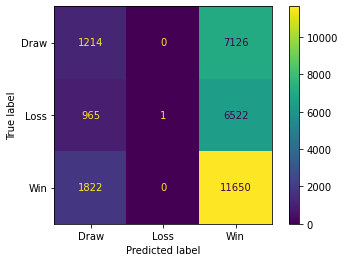

In [11]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y_encoder.classes_)
disp.plot()


# print(f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=y_encoder.classes_))

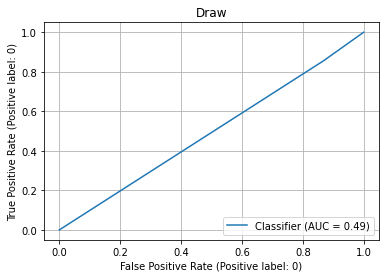

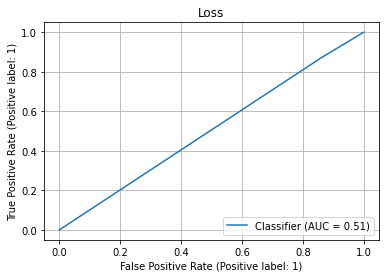

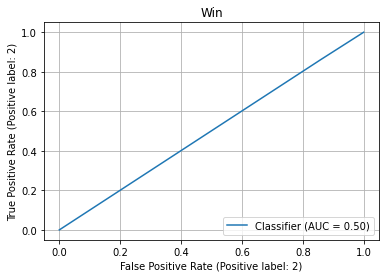

In [12]:
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{y_encoder.classes_[i]}')
  plt.grid()

## Support Vector Machine

In [ ]:
# accs = {}
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  svm = SVC()

  pipe = Pipeline(steps=[("pca", pca), ("svm", svm)])
  params = {"pca__n_components": [20, 50, 200, 500], 
            'svm__C':[0.001,0.1,10,100,10e3], 
            'svm__gamma':[0.1,0.01],
            'kernel': ['linear', 'poly', 'rbf']}

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)

  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)
  # accs[acc] = result.best_params_
  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))

# for k, v in accs.items():
#   print(k, v)

{0.5004026845637584: {'pca__n_components': 50, 'svm__C': 10, 'svm__gamma': 0.01}, 0.49771812080536915: {'pca__n_components': 140, 'svm__C': 10, 'svm__gamma': 0.01}, 0.49758324382384533: {'pca__n_components': 50, 'svm__C': 10, 'svm__gamma': 0.01}}


In [ ]:
pca = PCA(n_components=50)
svm = SVC(C=10, 
          gamma=0.01)

clf = Pipeline(steps=[("pca", pca), ("svm", svm)])

# clf = load('supportVectorClassifier.joblib')
clf.fit(X_train, y_train)
dump(clf, 'supportVectorClassifier.joblib')
files.download('supportVectorClassifier.joblib')
# y_pred = clf.predict(X_test)

# cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y_encoder.classes_)
# disp.plot()


# f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)

0.3389694039999283 0.3685
              precision    recall  f1-score   support

        Draw       0.29      0.27      0.28      2252
        Loss       0.26      0.26      0.26      2029
         Win       0.47      0.49      0.48      3719

    accuracy                           0.37      8000
   macro avg       0.34      0.34      0.34      8000
weighted avg       0.36      0.37      0.37      8000



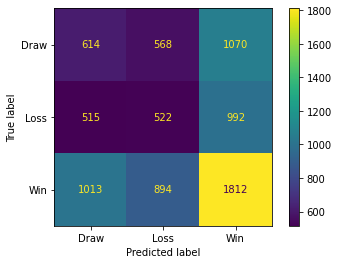

In [22]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=y_encoder.classes_)
disp.plot()


print(f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=y_encoder.classes_))

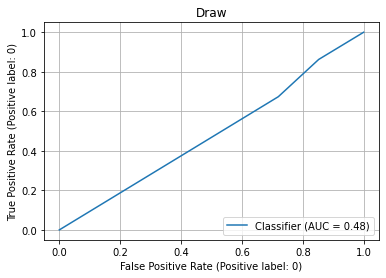

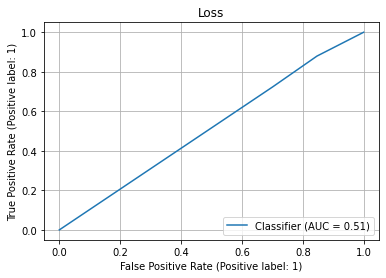

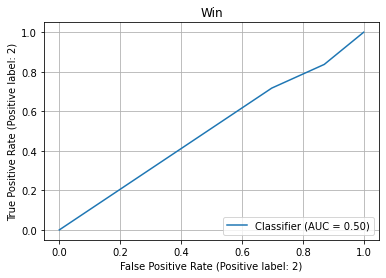

In [13]:
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{y_encoder.classes_[i]}')
  plt.grid()

## K-Nearest Neighbors Classifier

In [ ]:
# accs = {}
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  knn = KNeighborsClassifier(n_jobs=-1)

  pipe = Pipeline(steps=[("pca", pca), ("knn", knn)])
  params = {"pca__n_components": [20, 50, 200, 500],
            'knn__algorithm':['ball_tree', 'kd_tree', 'brute'], 
            'knn__leaf_size': [20, 30, 40]}

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)

  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)
  # accs[acc] = result.best_params_
  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))


# for k, v in accs.items():
#   print(k, v)

{0.3640268456375839: {'knn__algorithm': 'ball_tree', 'knn__leaf_size': 20, 'pca__n_components': 50}, 0.3868456375838926: {'knn__algorithm': 'brute', 'knn__leaf_size': 40, 'pca__n_components': 140}, 0.3770139634801289: {'knn__algorithm': 'kd_tree', 'knn__leaf_size': 40, 'pca__n_components': 140}}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.3334071732222137, 0.3539249146757679)

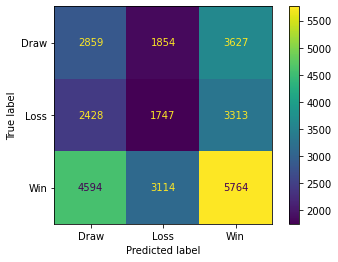

In [7]:
pca = PCA(n_components=140)
knn = KNeighborsClassifier(algorithm= 'kd_tree', 
                           leaf_size = 40, 
                           n_jobs=-1)

clf = Pipeline(steps=[("pca", pca), ("knn", knn)])

# clf = load('kNearestNeigborsClassifier.joblib')
clf.fit(X_train, y_train)
dump(clf, 'kNearestNeigborsClassifier.joblib')
files.download('kNearestNeigborsClassifier.joblib')
# y_pred = clf.predict(X_test)

# cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y_encoder.classes_)
# disp.plot()


# f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)

In [ ]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=y_encoder.classes_)
disp.plot()


# f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=y_encoder.classes_))

In [ ]:
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{y_encoder.classes_[i]}')
  plt.grid()

## Random Forest Classifier

In [ ]:
# accs = {}
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  randomForest = RandomForestClassifier(random_state=0, n_jobs=-1)

  pipe = Pipeline(steps=[("pca", pca), ("randomForest", randomForest)])
  params = {"pca__n_components": [20, 50, 200, 500],
            'randomForest__n_estimators':[80, 100, 120]}

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)

  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)
  # accs[acc] = result.best_params_
  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))

# for k, v in accs.items():
#   print(k, v)

{0.47838926174496643: {'pca__n_components': 20, 'randomForest__n_estimators': 100}, 0.4754362416107383: {'pca__n_components': 20, 'randomForest__n_estimators': 120}, 0.4712674543501611: {'pca__n_components': 20, 'randomForest__n_estimators': 120}}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.4244256210424611, 0.48440273037542664)

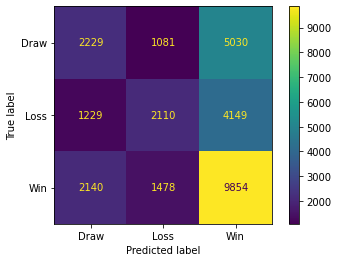

In [13]:
pca = PCA(n_components=20)
randomForest = RandomForestClassifier(n_estimators=120, 
                                      random_state=0, 
                                      n_jobs=-1)

clf = Pipeline(steps=[("pca", pca), ("randomForest", randomForest)])

# clf = load('randomForestClassifier.joblib') 
clf.fit(X_train, y_train)
dump(clf, 'randomForestClassifier.joblib')
files.download('randomForestClassifier.joblib')
# y_pred = clf.predict(X_test)

# cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y_encoder.classes_)
# disp.plot()


# f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)

In [ ]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=y_encoder.classes_)
disp.plot()


# f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=y_encoder.classes_))

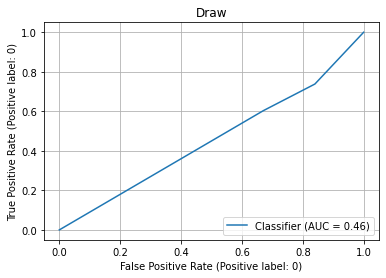

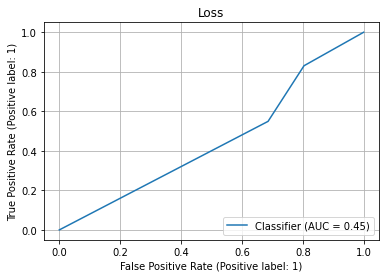

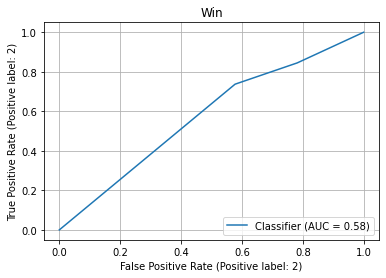

In [11]:
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{y_encoder.classes_[i]}')
  plt.grid()

## AdaBoost Classifier

In [ ]:
# accs = {}
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  adaBoost = AdaBoostClassifier(random_state=0)

  pipe = Pipeline(steps=[("pca", pca), ("adaBoost", adaBoost)])
  params = {"pca__n_components": [20, 50, 200, 500],
            'adaBoost__n_estimators':[30, 50, 80],
            'adaBoost__learning_rate': [0.5, 1.0, 1.5]}

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)

  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)
  # accs[acc] = result.best_params_
  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))

>acc=0.501, est=0.496, cfg={'adaBoost__learning_rate': 0.5, 'adaBoost__n_estimators': 30, 'pca__n_components': 20}
>acc=0.491, est=0.499, cfg={'adaBoost__learning_rate': 0.5, 'adaBoost__n_estimators': 50, 'pca__n_components': 140}
>acc=0.500, est=0.498, cfg={'adaBoost__learning_rate': 0.5, 'adaBoost__n_estimators': 30, 'pca__n_components': 20}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.22575742387669814, 0.46290102389078497)

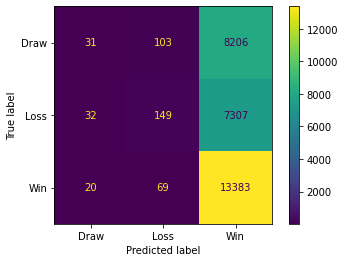

In [8]:
pca = PCA(n_components=20)
adaBoost = AdaBoostClassifier(n_estimators=50, 
                              learning_rate=0.5, 
                              random_state=0)

clf = Pipeline(steps=[("pca", pca), ("adaBoost", adaBoost)])

# clf = load('adaBoostClassifier.joblib') 
clf.fit(X_train, y_train)
dump(clf, 'adaBoostClassifier.joblib')
files.download('adaBoostClassifier.joblib')


In [ ]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y_encoder.classes_)
disp.plot()


# f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=y_encoder.classes_))

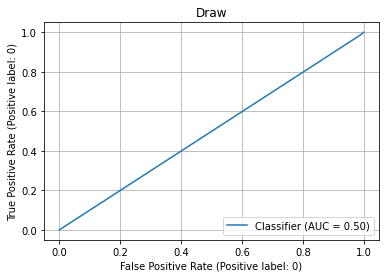

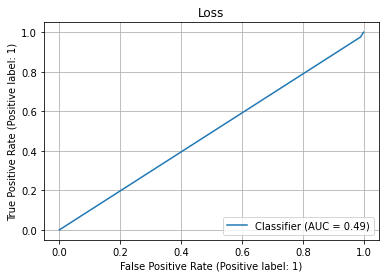

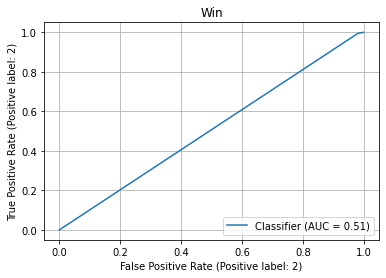

In [9]:
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{y_encoder.classes_[i]}')
  plt.grid()

## Gradient Boosting Classifier

In [15]:
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]

  pca = PCA()
  gradBoost = GradientBoostingClassifier(random_state=0)

  pipe = Pipeline(steps=[("pca", pca), ("gradBoost", gradBoost)])
  params = {"pca__n_components": [20, 50, 200, 500],
            'gradBoost__n_estimators':[30, 50, 80],
            'gradBoost__learning_rate': [0.5, 1.0, 1.5]}

  clf = GridSearchCV(pipe, params, cv = 3, n_jobs=-1)
  # clf =  RandomizedSearchCV(pipe, params, cv = 3, random_state=0, n_jobs=-1)
 

  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  y_pred_cv = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, y_pred_cv)
  # accs[acc] = result.best_params_
  print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, 
                                         result.best_params_))

>acc=0.447, est=0.439, cfg={'gradBoost__learning_rate': 0.5, 'gradBoost__n_estimators': 30, 'pca__n_components': 500}
>acc=0.453, est=0.451, cfg={'gradBoost__learning_rate': 0.5, 'gradBoost__n_estimators': 30, 'pca__n_components': 200}
>acc=0.448, est=0.437, cfg={'gradBoost__learning_rate': 0.5, 'gradBoost__n_estimators': 30, 'pca__n_components': 500}
>acc=0.452, est=0.458, cfg={'gradBoost__learning_rate': 0.5, 'gradBoost__n_estimators': 30, 'pca__n_components': 500}
>acc=0.425, est=0.450, cfg={'gradBoost__learning_rate': 0.5, 'gradBoost__n_estimators': 50, 'pca__n_components': 50}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.3412899781223519, 0.4998976109215017)

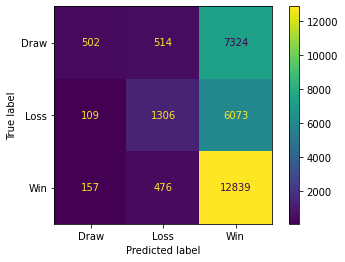

In [6]:
pca = PCA(n_components=200)
gradBoost = GradientBoostingClassifier(n_estimators=30, 
                                       learning_rate=0.5, 
                                       random_state=0)

clf = Pipeline(steps=[("pca", pca), ("gradBoost", gradBoost)])

# clf = load('gradientBoostingClassifier.joblib')
clf.fit(X_train, y_train)
dump(clf, 'gradientBoostingClassifier.joblib')
files.download('gradientBoostingClassifier.joblib')


In [ ]:
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=y_encoder.classes_)
disp.plot()


# f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=y_encoder.classes_))

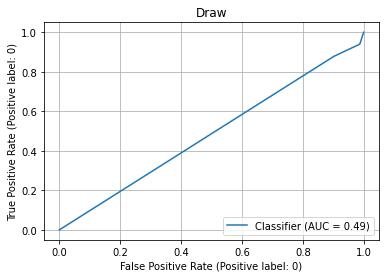

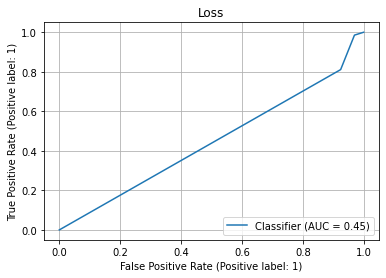

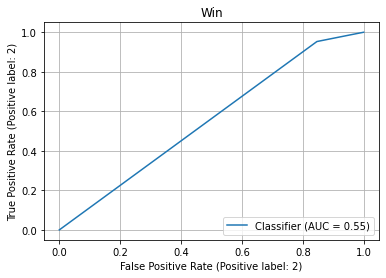

In [7]:
for i in range(len(np.unique(y_test))):
  RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=i)
  plt.title(f'{y_encoder.classes_[i]}')
  plt.grid()